# Оценка риска ДТП

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика:

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
Для модели выбрать
* тип виновника — только машина (car).
* Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
* Для моделирования ограничиться данными за 2012 год — они самые свежие.

Обязательное условие — учесть фактор возраста автомобиля.
На основе модели исследовать основные факторы ДТП.
Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
Какие ещё факторы нужно учесть?
Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Установка и импорт необходимых библиотек

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

from sqlalchemy import create_engine

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, \
                            f1_score, recall_score, precision_score, \
                            precision_recall_curve, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression

import optuna

import lightgbm as lgb

from catboost import CatBoostClassifier

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
pd.options.mode.chained_assignment = None

In [5]:
def info(df):

    display('------------------------------------------------------------------------')
    display('********************** Размер набора данных ****************************')
    display(f'Набор данных сподержит: {df.shape[1]} признаков, включая целевой')
    display(f'                     и: {df.shape[0]} наблюдений')
    display('------------------------------------------------------------------------')


    display('**************** 10 случайных наблюдений набора данных *****************')
    display(df.sample(10))
    display('------------------------------------------------------------------------')


    display('********************** Информация о наборе данных **********************')
    display(df.info())
    display('------------------------------------------------------------------------')


    display('********* Основные статистические характеристики набора данных *********')
    display(df.describe())
    display('------------------------------------------------------------------------')

## Подключение к базе. Загрузка таблицы sql

In [6]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

In [8]:
engine = create_engine(connection_string)

## Первичное исследование таблиц

### Таблица collisions (информация о происшествиях)

In [9]:
# Выгрузим 10 строк таблицы collisions
query =  '''

SELECT *
FROM collisions
LIMIT 10

'''

pd.read_sql_query(query, con = engine)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


#### Вывод:
1. В таблице есть пропуски.
2. Не совпадают названия столбцов. В ER - диаграмме и в выгруженной таблице столбец - основной фактор аварии `primary_collision_factor`, а в описании данных -  `PRIMARY_COLL_FACTOR`.
3. Не совпадают названия столбцов. В ER - диаграмме и в выгруженной таблице столбец - устройство управления `control_device`, а в описании данных -  `CONTROL_CONDITION_1`. И непонятно, что несет этот столбец.

### Таблица case_ids

In [10]:
# Выгрузим 10 строк таблицы case_ids
query =  '''

SELECT *
FROM case_ids
LIMIT 10

'''

pd.read_sql_query(query, con = engine)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


#### Вывод:
1. Отсутствует описание данных.
2. Не совпадают названия столбцов. В ER - диаграмме - `Case_id`, а в выгруженной таблице - `db_year`.

### Таблица vehicles (описание автомобиля)

In [11]:
# Выгрузим 10 строк таблицы vehicles
query =  '''

SELECT *
FROM vehicles
LIMIT 10

'''

pd.read_sql_query(query, con = engine)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


#### Вывод:
1. В ER - диаграмме и в таблице есть столбец `party_number`, но в описании он отсутствует. Также столбец `party_number` присутствует в таблице `parties` и описании к ней. Вероятно, столбец `party_number` ошибочно находится в таблице `vehicles`.

### Таблица parties (описание участников происшествия)

In [12]:
# Выгрузим 10 строк таблицы parties
query =  '''

SELECT *
FROM parties
LIMIT 10

'''

pd.read_sql_query(query, con = engine)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


### Вывод
1. Все таблицы имеют набор данных;
2. Количество таблиц соответствует условию задачи.
3. Общий ключ для связи таблиц имеется - case_id.
4. В таблице collisions (информация о происшествиях):
    1. Не совпадают названия столбцов. В ER - диаграмме и в выгруженной таблице столбец - основной фактор аварии `primary_collision_factor`, а в описании данных -  `PRIMARY_COLL_FACTOR`.
    2. Не совпадают названия столбцов. В ER - диаграмме и в выгруженной таблице столбец - устройство управления `control_device`, а в описании данных -  `CONTROL_CONDITION_1`. И непонятно, что несет этот столбец.
5. В таблице case_ids:
    1. Отсутствует описание данных.
    2. Не совпадают названия столбцов. В ER - диаграмме - `Case_id`, а в выгруженной таблице - `db_year`.
6. В таблице vehicles (описание автомобиля):
    1. В ER - диаграмме и в таблице есть столбец `party_number`, но в описании он отсутствует. Также столбец `party_number` присутствует в таблице `parties` и описании к ней. Вероятно, столбец `party_number` ошибочно находится в таблице `vehicles`.

##  Статистический анализ факторов ДТП

### В какие месяцы происходит наибольшее количество аварий?

Посмотрим в какие месяцы происходит наибольшее количество аварий:

In [13]:
# количество проишествий по месяцам
query = """
SELECT COUNT(case_id) AS collision_count, date_trunc('month', collision_date)::date AS collision_date
FROM collisions
GROUP BY date_trunc('month', collision_date)
"""
#подключение к баде
count_collions = pd.read_sql_query(query, con=engine)
count_collions.sample(10)

,collision_count,collision_date
53,1,2013-07-01
43,622,2012-08-01
24,31926,2011-01-01
27,31377,2011-04-01
26,34585,2011-03-01
11,36060,2009-12-01
13,31918,2010-02-01
9,37835,2009-10-01
6,35161,2009-07-01
48,144,2013-01-01


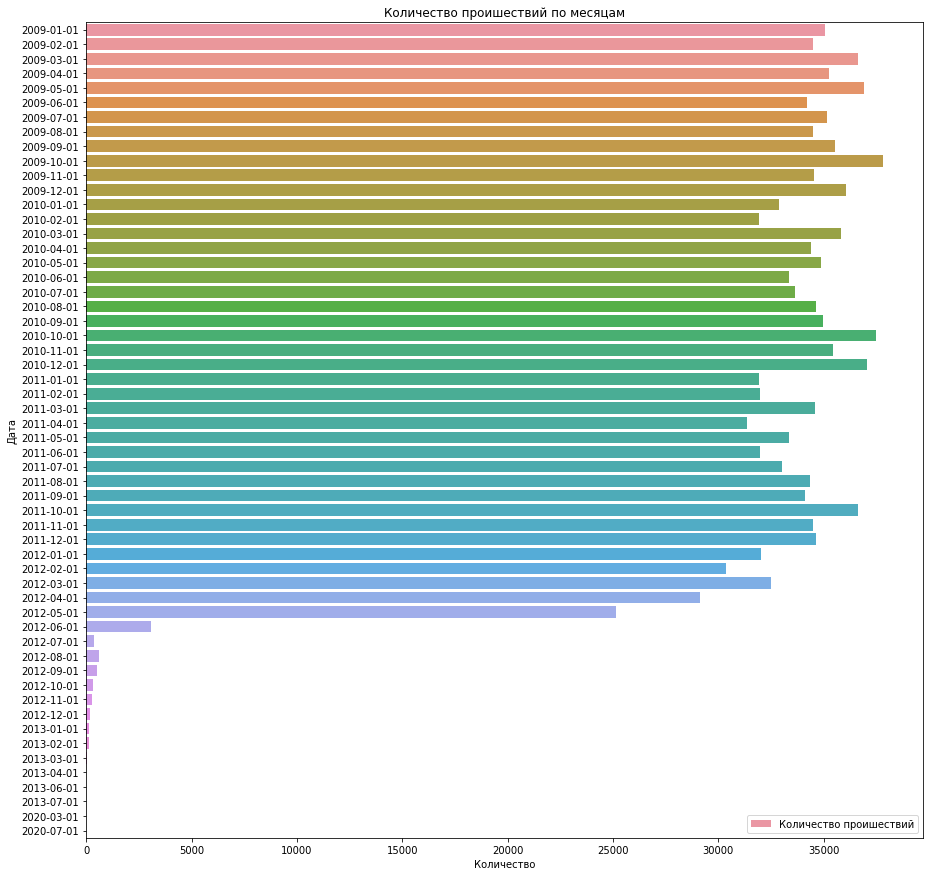

In [14]:
#установка размера
f, ax = plt.subplots(figsize=(15, 15))

#отрисова
sns.barplot(data=count_collions,
            x='collision_count',
            y='collision_date',
            label = 'Количество проишествий',
            ax=ax)

ax.legend(ncol=1,
          loc="lower right")

ax.set(xlabel="Количество",
       ylabel="Дата")

plt.title("Количество проишествий по месяцам")
plt.show()

Наблюдается закономерность, наибольшее количество аварий происходит в октябре. Возможно это связано с ухудшением погодных условий и несвоевременной замены резины на зимнюю.

### Постановка аналитических задач

1. Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП;
2. Провести анализ серьёзности повреждений транспортного средства, исходя из дорожного состояния в момент ДТП;
3. Выявить самые частые причины ДТП;
4. Выявить самые частые нарушения;
5. Влияние погоды на вероятность ДТП;
6. Влияние освещения на вероятность возникновения ДТП

#### Анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП:

In [15]:
query = '''

SELECT DISTINCT road_surface, collision_damage,
COUNT(collision_damage) OVER (PARTITION BY road_surface ORDER BY collision_damage) AS col_count
FROM collisions c
WHERE case_id IN (SELECT DISTINCT case_id
                  FROM parties p
                  WHERE party_type = 'car')
ORDER BY road_surface, col_count

'''

damage_collisions = pd.read_sql_query(query, con=engine)
damage_collisions

,road_surface,collision_damage,col_count
0,dry,fatal,9746
1,dry,middle damage,156935
2,dry,scratch,463545
3,dry,severe damage,490510
4,dry,small damage,1232957
5,slippery,fatal,12
6,slippery,middle damage,237
7,slippery,scratch,541
8,slippery,severe damage,601
9,slippery,small damage,1359


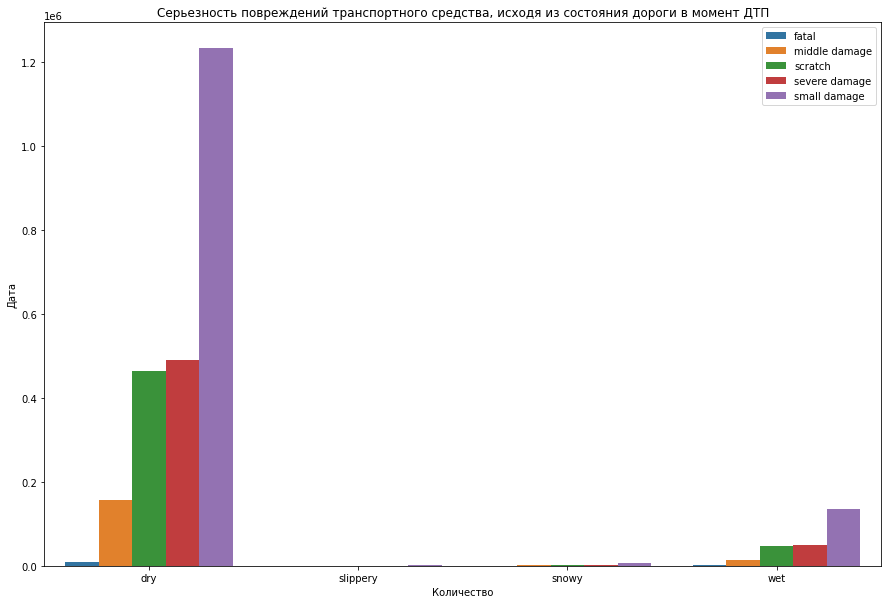

In [16]:
#установка размера
f, ax = plt.subplots(figsize=(15, 10))

#
sns.barplot(data=damage_collisions,
            x='road_surface',
            y = 'col_count',
            hue  = 'collision_damage')

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Количество",
       ylabel="Дата")

plt.title("Серьезность повреждений транспортного средства, исходя из состояния дороги в момент ДТП")
plt.show()

##### Вывод
Подавляющее число ДТП происходят когда дорожное покрыние сухое. Также можно сделать вывод, что пропрции серьезности повреждений сохраняются независимо от времени суток.

#### Автомобили с каким типом кузова чаще получают серьезные повреждения при ДТП

In [17]:
query = '''
SELECT
  *,
  col_count / SUM(col_count) OVER (PARTITION BY vehicle_type) AS prcnt
FROM
  (
    SELECT
      DISTINCT collision_damage,
      vehicle_type,
      COUNT(collision_damage) OVER (
        PARTITION BY vehicle_type
        ORDER BY
          collision_damage
      ) AS col_count
    FROM
      (
        SELECT
          case_id,
          collision_damage
        FROM
          collisions
      ) c
      JOIN (
        SELECT
          case_id,
          vehicle_type
        FROM
          vehicles
      ) v ON c.case_id = v.case_id
  ) t

'''
#подключение к базе
car_crash = pd.read_sql_query(query, con=engine)
#сразу заполним пропуски
car_crash = car_crash.fillna('unknown')
car_crash

,collision_damage,vehicle_type,col_count,prcnt
0,severe damage,coupe,442780,0.437932
1,middle damage,coupe,140402,0.138865
2,scratch,coupe,418973,0.414385
3,fatal,coupe,8916,0.008818
4,severe damage,hatchback,45595,0.420385
5,middle damage,hatchback,20362,0.187737
6,fatal,hatchback,2786,0.025687
7,scratch,hatchback,39717,0.366190
8,middle damage,minivan,22573,0.212981
9,fatal,minivan,527,0.004972


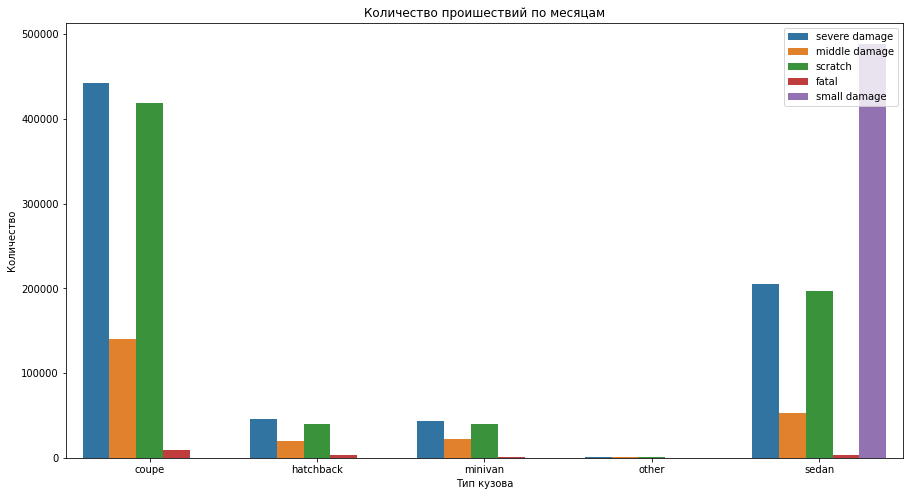

In [18]:

f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data =car_crash,
            x='vehicle_type',
            y = 'col_count',
            hue  = 'collision_damage')

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Тип кузова",
       ylabel="Количество")

plt.title("Количество проишествий по месяцам")
plt.show()

В количественном отношении во всех категориях кроме легких повреждений лидируют машины с типом кузова купе.

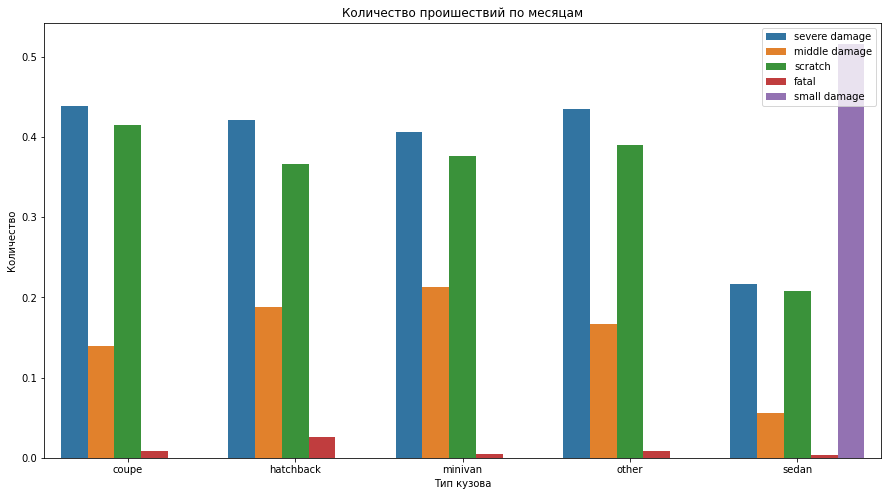

In [19]:
#установка размера
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data =car_crash,
            x='vehicle_type',
            y = 'prcnt',
            hue  = 'collision_damage')

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(xlabel="Тип кузова",
       ylabel="Количество")

plt.title("Количество проишествий по месяцам")
plt.show()

В процентном соотношении картина поменялась. Категория Other слишком маленькая, ее можно не рассматривать. В категории Серьезные повреждения и царапины все еще лидируют Купе. В категории средние повреждения лидируют Минивены а в категории не подлежит восстановлению - лидер Хачбек. Мне кажется в наших данных есть аномалия в разрезе малые повреждения. К сожалению в категории кузова Седан у нас имеется аномалии и рассматривать ее в данной статистике не представляется возможным.

#### Самые частые причины ДТП

In [20]:
query = '''
SELECT DISTINCT primary_collision_factor,
       COUNT(primary_collision_factor) count_collision_factor
FROM collisions
WHERE primary_collision_factor != 'unknown'
GROUP BY primary_collision_factor
ORDER BY count_collision_factor DESC
'''
collisions_reasons = pd.read_sql_query(query, con=engine)
collisions_reasons

,primary_collision_factor,count_collision_factor
0,vehicle code violation,1316453
1,other than driver,29780
2,other improper driving,8470
3,fell asleep,117


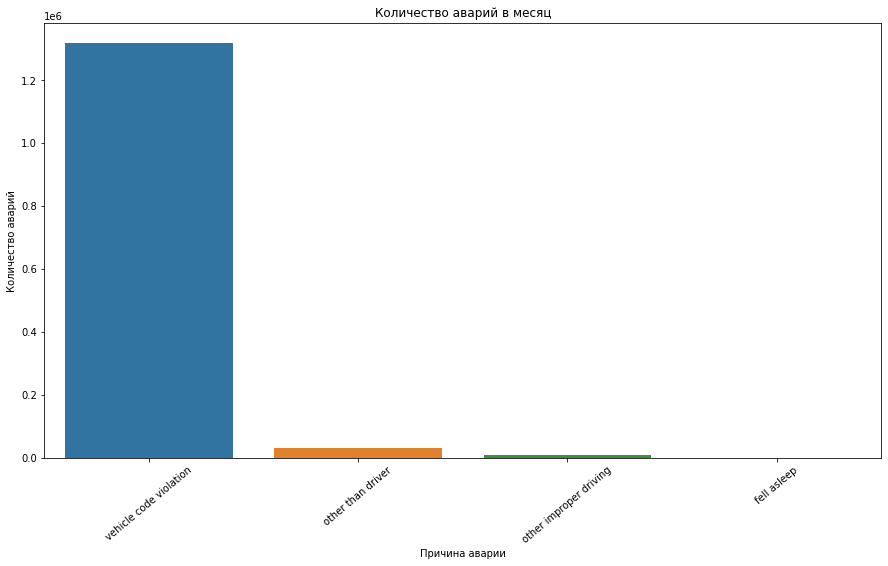

In [21]:
plt.figure(figsize=(15, 8))

sns.barplot(data = collisions_reasons, x='primary_collision_factor', y='count_collision_factor')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=40)
plt.xlabel('Причина аварии')
plt.ylabel('Количество аварий')
plt.show()

Самой частой причиной аварий является нарушение пдд

#### Самые частые нарушения

In [22]:
query = '''
SELECT DISTINCT pcf_violation_category,
       COUNT(pcf_violation_category) count_pcf_violation_category
FROM collisions
GROUP BY pcf_violation_category
ORDER BY count_pcf_violation_category DESC
LIMIT 5
'''
violation_category = pd.read_sql_query(query, con=engine)
violation_category

,pcf_violation_category,count_pcf_violation_category
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962


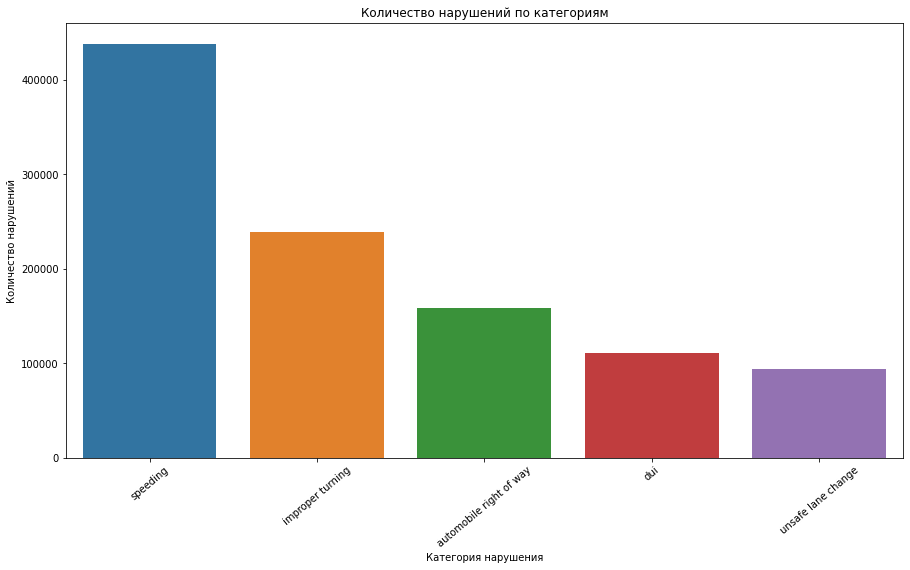

In [23]:
plt.figure(figsize=(15, 8))
sns.barplot(data = violation_category, x='pcf_violation_category', y='count_pcf_violation_category')
plt.title('Количество нарушений по категориям')
plt.xticks(rotation=40)
plt.xlabel('Категория нарушения')
plt.ylabel('Количество нарушений')
plt.show()

Самым частым нарушением является привышение скорости. На втором месте находится неправильный поворот

#### Влияние погоды на веротятность возникновения ДТП

In [24]:
query = '''
SELECT DISTINCT weather_1,
       COUNT(case_id) count_collisions
FROM collisions
GROUP BY weather_1
ORDER BY count_collisions DESC
'''
weather_damage = pd.read_sql_query(query, con=engine)
weather_damage

,weather_1,count_collisions
0,clear,1121048
1,cloudy,203030
2,raining,57976
3,None,7259
4,fog,6156
5,snowing,2571
6,other,1516
7,wind,444


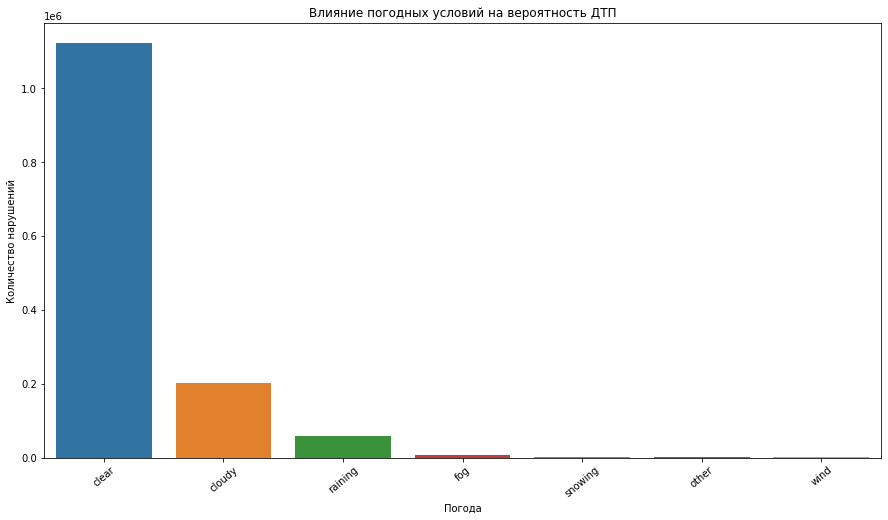

In [25]:
plt.figure(figsize=(15, 8))
sns.barplot(data = weather_damage, x='weather_1', y='count_collisions')
plt.title('Влияние погодных условий на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Погода')
plt.ylabel('Количество нарушений')
plt.show()

Чаще всего дтп происходят в ясную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь

#### Влияние освещения на вероятность возникновения ДТП

In [26]:
query = '''
SELECT DISTINCT lighting,
       COUNT(case_id) count_collisions
FROM collisions
GROUP BY lighting
ORDER BY count_collisions DESC
'''
lighting_damage = pd.read_sql_query(query, con=engine)
lighting_damage

,lighting,count_collisions
0,daylight,941950
1,dark with street lights,291887
2,dark with no street lights,106170
3,dusk or dawn,47199
4,None,8593
5,dark with street lights not functioning,4201


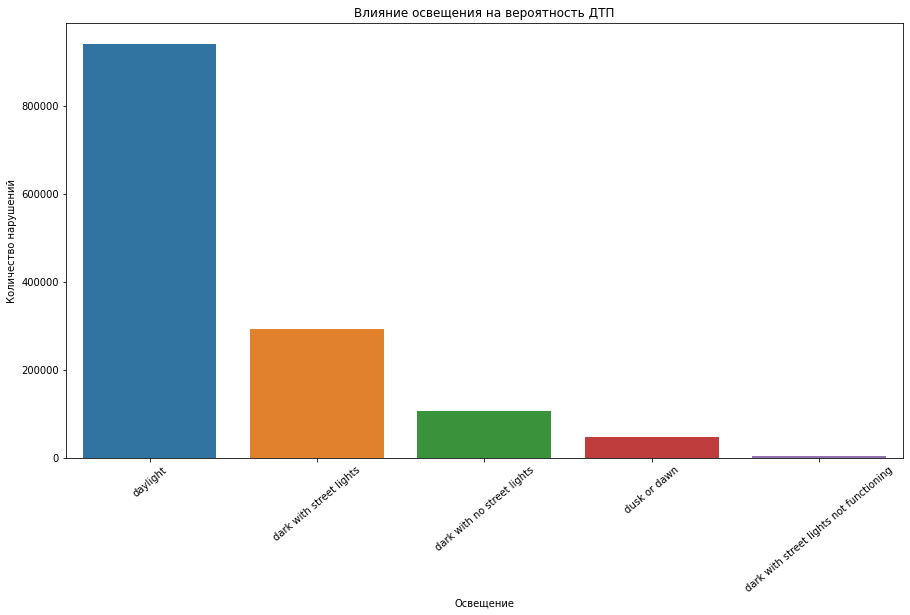

In [27]:
plt.figure(figsize=(15, 8))
sns.barplot(data = lighting_damage, x='lighting', y='count_collisions')
plt.title('Влияние освещения на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Освещение')
plt.ylabel('Количество нарушений')
plt.show()

Можно сделать вывод, что освещение не особо влияет на вероятность возникновения дтп, хотя при ночном освещении риск все же есть

### Вывод
1. наибольшее количество аварий приходится на октябрь месяц
2. чаще всего дтп происходят когда дорогая сухая,но так же можно увидеть что мокрая дорога может повлиять на вероятность возникновения ДТП
3. ДТП чаще всего случаются на дорогах без повреждений. Однако, дороги с зоной строительства или ремонта так же увлечивают риск возникновения ДТП
4. самой частой причиной аварий является нарушение пдд
5. чаще всего дтп происходят в нормальную погоду, но все же наиболее высокий риск попасть в дтп в облачную погоду или в дождь
6. самыми частыми нарушениями является привышение скорости. На втором месте находится неправильный поворот освещение не особо влияет на вероятность возникновения дтп, хотя при ночном освещении риск все же есть

## Создайте модель для оценки водительского риска

Подготовьте набор данных на основе первичного предположения заказчика:

Подготовка набора данных на основе первичного предположения заказчика:

* тип виновника — только машина (car);
* случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH;
* данные только за 2012 год.

In [28]:
query = '''
SELECT
  at_fault,
  vehicle_type,
  vehicle_transmission,
  vehicle_age,
  party_type,
  insurance_premium,
  party_sobriety,
  party_drug_physical,
  cellphone_in_use,
  county_city_location,
  county_location,
  distance,
  direction,
  intersection,
  weather_1,
  location_type,
  collision_damage,
  party_count,
  primary_collision_factor,
  pcf_violation_category,
  type_of_collision,
  motor_vehicle_involved_with,
  road_surface,
  road_condition_1,
  lighting,
  control_device,
  collision_date,
  collision_time
FROM
    collisions as c
    JOIN parties as p ON p.case_id = c.case_id
    JOIN vehicles as v ON v.case_id = c.case_id
        AND p.party_number = v.party_number
WHERE
  p.party_type = 'car'
  AND c.collision_damage != 'scratch'
  AND EXTRACT(
    year
    FROM
      c.collision_date
  ) = 2012;
'''
#подключение к базе and p.party_number = v.party_number
df = pd.read_sql_query(query, con=engine)

In [29]:
info(df)

'------------------------------------------------------------------------'

'********************** Размер набора данных ****************************'

'Набор данных сподержит: 28 признаков, включая целевой'

'                     и: 56248 наблюдений'

'------------------------------------------------------------------------'

'**************** 10 случайных наблюдений набора данных *****************'

,at_fault,vehicle_type,vehicle_transmission,vehicle_age,party_type,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
25184,0,sedan,manual,8.0,car,23.0,had not been drinking,None,0.0,1942,los angeles,155.0,east,0.0,clear,None,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-01-30,18:10:00
54917,0,coupe,auto,5.0,car,32.0,had not been drinking,None,0.0,2700,monterey,528.0,north,0.0,clear,highway,middle damage,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2012-06-04,22:27:00
49859,1,sedan,manual,NaN,car,62.0,had not been drinking,None,0.0,3300,riverside,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with no street lights,functioning,2012-03-19,20:00:00
2389,1,sedan,manual,2.0,car,22.0,had not been drinking,None,0.0,1942,los angeles,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,None,dark with street lights,functioning,2012-04-13,22:00:00
17614,1,sedan,manual,1.0,car,40.0,had not been drinking,None,0.0,4313,santa clara,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2012-03-07,15:48:00
20639,1,coupe,manual,7.0,car,46.0,had not been drinking,sleepy/fatigued,NaN,1992,los angeles,0.0,None,1.0,clear,None,middle damage,1,vehicle code violation,improper turning,hit object,fixed object,dry,normal,dark with street lights,functioning,2012-01-25,02:35:00
48048,1,coupe,manual,15.0,car,93.0,had not been drinking,None,0.0,1972,los angeles,75.0,south,0.0,clear,None,middle damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,none,2012-01-13,09:32:00
16513,1,coupe,auto,3.0,car,21.0,None,under drug influence,NaN,4004,san luis obispo,200.0,east,0.0,raining,None,middle damage,4,vehicle code violation,dui,head-on,parked motor vehicle,wet,normal,daylight,none,2012-03-17,14:16:00
49369,1,sedan,manual,2.0,car,17.0,had not been drinking,None,0.0,3600,san bernardino,1056.0,north,0.0,clear,highway,severe damage,2,vehicle code violation,speeding,broadside,other motor vehicle,dry,normal,daylight,none,2012-04-29,11:45:00
21209,1,sedan,manual,3.0,car,19.0,had not been drinking,None,NaN,3616,san bernardino,232.0,east,0.0,raining,None,small damage,1,vehicle code violation,speeding,broadside,fixed object,wet,normal,dark with street lights,functioning,2012-01-23,19:11:00


'------------------------------------------------------------------------'

'********************** Информация о наборе данных **********************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   at_fault                     56248 non-null  int64  
 1   vehicle_type                 56248 non-null  object 
 2   vehicle_transmission         55389 non-null  object 
 3   vehicle_age                  54554 non-null  float64
 4   party_type                   56248 non-null  object 
 5   insurance_premium            55701 non-null  float64
 6   party_sobriety               55376 non-null  object 
 7   party_drug_physical          2857 non-null   object 
 8   cellphone_in_use             51777 non-null  float64
 9   county_city_location         56248 non-null  object 
 10  county_location              56248 non-null  object 
 11  distance                     56248 non-null  float64
 12  direction                    43230 non-null  object 
 13  intersection    

None

'------------------------------------------------------------------------'

'********* Основные статистические характеристики набора данных *********'

,at_fault,vehicle_age,insurance_premium,cellphone_in_use,distance,intersection,party_count
count,56248.000000,54554.000000,55701.000000,51777.000000,5.624800e+04,56073.000000,56248.000000
mean,0.504427,4.856472,37.607170,0.020357,8.594387e+02,0.221533,2.075025
std,0.499985,3.234503,16.328721,0.141218,7.240295e+03,0.415282,0.798123
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000
25%,0.000000,3.000000,24.000000,0.000000,7.000000e+00,0.000000,2.000000
50%,1.000000,4.000000,34.000000,0.000000,1.350000e+02,0.000000,2.000000
75%,1.000000,7.000000,49.000000,0.000000,5.450000e+02,0.000000,2.000000
max,1.000000,161.000000,105.000000,1.000000,1.584000e+06,1.000000,10.000000


'------------------------------------------------------------------------'

Проведем исследовательский анализ данных и определим признаки на которых будет обучаться модель.

### EDA

#### Целевой признак - at_fault (виновник)

In [30]:
df.at_fault.value_counts()

1    28373
0    27875
Name: at_fault, dtype: int64

#### Тип кузова (vehicle_type)


In [31]:
df.vehicle_type.value_counts()

sedan    37180
coupe    19064
other        4
Name: vehicle_type, dtype: int64

In [32]:
df = df.drop(df[df['vehicle_type'] == 'other'].index)

In [33]:
df['vehicle_type'] = df['vehicle_type'].astype('category')

#### Время происшествия (collision_time)

In [34]:
df['collision_time'].head()

0    17:05:00
1    13:30:00
2    22:35:00
3    08:07:00
4    17:10:00
Name: collision_time, dtype: object

In [35]:
#удалим строки с пропусками в столбце collision_time
df = df.drop(df[df['collision_time'].isna()].index)

In [36]:
#оставим только часы, остальное уберем
df['collision_time'] = df['collision_time'].apply(lambda x: x.hour)
df['collision_time'].value_counts()

15    4867
17    4250
16    4153
14    4108
18    3694
13    3589
12    3327
11    2873
19    2565
7     2545
8     2515
10    2304
20    2160
9     2018
21    1881
22    1551
23    1373
2     1177
1     1139
6     1113
0     1062
3      708
5      683
4      501
Name: collision_time, dtype: int64

In [37]:
df['collision_time'] = df['collision_time'].astype('category')

#### collision_date

Cтолбец collision_date Очень важен, сложность вождения имеет зависимость от времени года, но в периоде, который мы рассматриваем у нас есть данные только по 5 месяцам. Алгоритм может переобучиться на этих месяцах и другие предсказывать хуже. В таком разрезе столбец нам не подходит, но из него можно извлечь информацию о дне недели. Это будет полезно.

Извлечем из столбца информацию о дне недели. Остальное удалим.

In [38]:
#оставим только часы, остальное уберем
df['collision_date'] = df['collision_date'].apply(lambda x: x.weekday())
df['collision_date'].value_counts()

5    9352
4    9264
6    8086
3    7681
2    7536
1    7179
0    7058
Name: collision_date, dtype: int64

In [39]:
df['collision_date'] = df['collision_date'].astype('category')

#### Дата происшествия (control_device)

In [40]:
df['control_device'].value_counts()

none               37509
functioning        18288
not functioning      116
obscured              29
Name: control_device, dtype: int64

Я не понял назначение данного устройства а в условиях задачи его смысл не раскрывается подробно. Будем изходить из того, что это что-то важное. Тогда not functioning и obscured - очень малое количество. По смыслу их можно заменить на none или удалить. Я заменю.

In [41]:
control_device_map = {
    'not functioning': 'none',
    'obscured':'none'
}

df['control_device'] = df['control_device'].apply(lambda x: control_device_map[x] if x in control_device_map else x)
df['control_device'].value_counts()

none           37654
functioning    18288
Name: control_device, dtype: int64

In [42]:
#удалим строки с пропусками в столбце control_device
df = df.drop(df[df['control_device'].isna()].index)

In [43]:
df['control_device'] = df['control_device'].astype('category')

#### Освещение (lighting)

In [44]:
df['lighting'].value_counts()

daylight                                   37912
dark with street lights                    10958
dark with no street lights                  5054
dusk or dawn                                1753
dark with street lights not functioning      134
Name: lighting, dtype: int64

Освещенность очень важный фактор. dark with street lights not functioning очень небольшая категория, посмотрим на качество. ЕЕ можно объединить с dark with no street lights. Так и сделаем. А так же удалим строки с пропусками в данной категории.

In [45]:
#удалим строки с пропусками в столбце lighting
df = df.drop(df[df['lighting'].isna()].index)

lighting_map = {
    'dark with street lights not functioning': 'dark with no street lights',
}

df['lighting'] = df['lighting'].apply(lambda x: lighting_map[x] if x in lighting_map else x)
df['lighting'].value_counts()

daylight                      37912
dark with street lights       10958
dark with no street lights     5188
dusk or dawn                   1753
Name: lighting, dtype: int64

In [46]:
df['lighting'] = df['lighting'].astype('category')

#### Дорожное состояние (road_condition_1)

In [47]:
df['road_condition_1'].value_counts()

normal            53711
construction        994
obstruction         246
other               222
holes               220
loose material      127
reduced width        72
flooded              32
Name: road_condition_1, dtype: int64

Состояние самой улицы важный фактор, но в категориях кроме norval маловато значений, однако все они свидетельствуют о проблемах, поэтому объединим их все в одну а пропуски удалим.

In [48]:
#удалим строки с пропусками в столбце road_condition_1
df = df.drop(df[df['road_condition_1'].isna()].index)

road_condition_map = {
    'construction': 'probem',
    'holes': 'probem',
    'obstruction': 'probem',
    'other': 'probem',
    'loose material': 'probem',
    'reduced width': 'probem',
    'flooded': 'probem'
}

df['road_condition_1'] = df['road_condition_1'].apply(lambda x: road_condition_map[x] if x in road_condition_map else x)
df['road_condition_1'].value_counts()

normal    53711
probem     1913
Name: road_condition_1, dtype: int64

In [49]:
df['road_condition_1'] = df['road_condition_1'].astype('category')

#### Состояние дороги (road_surface)

In [50]:
df['road_surface'].value_counts()

dry         49765
wet          5191
snowy         353
slippery       40
Name: road_surface, dtype: int64

Важный фактор. категорию slippery объединим со snowy. Они обе скользкие. Пропуски удалим.

In [51]:
#удалим строки с пропусками в столбце road_condition_1
df = df.drop(df[df['road_surface'].isna()].index)

road_surface_map = {
    'slippery': 'snowy'
}

df['road_surface'] = df['road_surface'].apply(lambda x: road_surface_map[x] if x in road_surface_map else x)
df['road_surface'].value_counts()

dry      49765
wet       5191
snowy      393
Name: road_surface, dtype: int64

In [52]:
df['road_surface'] = df['road_surface'].astype('category')

#### Дополнительные участники ДТП (motor_vehicle_involved_with)

In [53]:
df['motor_vehicle_involved_with'].value_counts()

other motor vehicle               40618
fixed object                       8149
non-collision                      2241
other object                       1684
parked motor vehicle               1477
bicycle                             407
motor vehicle on other roadway      406
animal                              230
train                                16
Name: motor_vehicle_involved_with, dtype: int64

motor_vehicle_involved_with - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта с которым произошло столкновение может существовать. Например fixed object не может двигаться и не может быть виновником ДТП.

train и animal - очень маленькие категории. При плохом качестве модели попробуем их перенести в other object. Пока оставим как есть.

In [54]:
#удалим строки с пропусками в столбце motor_vehicle_involved_with
df = df.drop(df[df['motor_vehicle_involved_with'].isna()].index)

#сменим тип столбца
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].astype('category')

#### Тип аварии (type_of_collision)

In [55]:
df['type_of_collision'].value_counts()

rear end      18507
broadside     11721
sideswipe      9117
hit object     8496
head-on        3228
overturned     2252
other          1686
Name: type_of_collision, dtype: int64

type_of_collision - тип проишествия. Виновность в дтп может зависить от типа столкновения.

In [56]:
#удалим строки с пропусками в столбце type_of_collision
df = df.drop(df[df['type_of_collision'].isna()].index)

#сменим тип столбца
df['type_of_collision'] = df['type_of_collision'].astype('category')

#### Основной фактор аварии (primary_collision_factor)

In [57]:
df['primary_collision_factor'].value_counts()

vehicle code violation    52747
other than driver          1116
unknown                     819
other improper driving      221
fell asleep                   3
Name: primary_collision_factor, dtype: int64

In [58]:
df['pcf_violation_category'].value_counts()

speeding                             17905
improper turning                      8013
automobile right of way               6966
dui                                   6068
unsafe lane change                    4590
traffic signals and signs             3288
unsafe starting or backing            1347
wrong side of road                    1344
other than driver (or pedestrian)     1116
following too closely                  994
unknown                                877
other hazardous violation              503
improper passing                       470
pedestrian violation                   308
other improper driving                 221
pedestrian right of way                110
other equipment                         82
impeding traffic                        33
hazardous parking                       28
brakes                                  10
fell asleep                              3
lights                                   3
Name: pcf_violation_category, dtype: int64

Данные содержащиеся в столбцах `primary_collision_factor` и `pcf_violation_category` не известны на момент посодки в автомобиль, поэтому не будеи обучать на них модель и удалим их.

In [59]:
##удалим строки с пропусками в столбце pcf_violation_category
#df = df.drop(df[df['#'].isna()].index)
#
#pcf_violation_category_map = {
#    'fell asleep': 'other improper driving',
#    'lights': 'other improper driving',
#    'hazardous parking': 'other improper driving',
#    'impeding traffic': 'other improper driving',
#    'brakes': 'other improper driving'
#}
#
#df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: pcf_violation_category_map[x] if x in pcf_violation_category_map else x)
#
##удалим лишний столбец
#df = df.drop('primary_collision_factor', axis = 1)
#
##сменим тип столбца
#df['pcf_violation_category'] = df['pcf_violation_category'].astype('category')
#df['pcf_violation_category'].value_counts()

In [60]:
df = df.drop('primary_collision_factor', axis = 1)

In [61]:
df = df.drop('pcf_violation_category', axis = 1)

#### Количество участников (party_count)

In [62]:
df['party_count'].value_counts()

2     34961
1      9889
3      7381
4      1987
5       571
6       141
7        43
9        17
8        14
10        3
Name: party_count, dtype: int64

Для определения виновности имеет значение количество участников. Если участник 1 - то в целом понятно, что он вероятно виновен, поэтому объединим все что больше одного в одну категорию.

In [63]:
df['party_count'] = df['party_count'].apply(lambda x: 1 if x == 1 else 2 )
df['party_count'] = df['party_count'].astype('category')
df['party_count'].value_counts()

2    45118
1     9889
Name: party_count, dtype: int64

#### Серьёзность происшествия (collision_damage)

collision_damage - ущерб при аварии. Ущерб при аварии на мой взгляд не зависит от виновности или не виновности участника ДТП. удалим столбец.

In [64]:
#удалим строки с пропусками в столбце collision_damage
df = df.drop('collision_damage', axis = 1)

#### Тип дороги (location_type)

In [65]:
df['location_type'].value_counts()

highway         21029
ramp             3219
intersection     1316
Name: location_type, dtype: int64

Поведение водителей разнится в зависимости от нахождения на шоссе и в городе. оставим этот столбец. пропуски заполним значением other

In [66]:
df['location_type'] = df['location_type'].fillna('other')

df['location_type'] = df['location_type'].astype('category')
df['location_type'].value_counts()

other           29443
highway         21029
ramp             3219
intersection     1316
Name: location_type, dtype: int64

#### Погода (weather_1)

In [67]:
df['weather_1'].value_counts()

clear      44121
cloudy      8283
raining     2126
fog          178
snowing      154
other         33
wind          11
Name: weather_1, dtype: int64

Этот столбец важен, он влияет на водителя. Только категорию wind объединим с other. Пропуски заполним other.

In [68]:
df['weather_1'] = df['weather_1'].fillna('other')

weather_map = {
    'wind': 'other'
}

df['weather_1'] = df['weather_1'].apply(lambda x: weather_map[x] if x in weather_map else x)

#сменим тип столбца
df['weather_1'] = df['weather_1'].astype('category')
df['weather_1'].value_counts()

clear      44121
cloudy      8283
raining     2126
fog          178
snowing      154
other        145
Name: weather_1, dtype: int64

#### Является ли место происшествие перекрёстком (intersection)

Перекресток является фактором повышающим вероятность аварии. Но никак не влияет на вероятность быть в ней виновным. Удаляем.

In [69]:
df = df.drop('intersection', axis = 1)

#### Направление движения (direction)

In [70]:
df['direction'].value_counts()

north    11901
south    11626
west      9521
east      9320
Name: direction, dtype: int64

От направления зависит куда светит солнце. По хорошему можно сделать дополнительный признак. Объединив время и направление. Сделаем это если качество модели без этого будет низким. Пропуски заполним значением unknown

In [71]:
df['direction'] = df['direction'].fillna('unknown')
df['direction'] = df['direction'].astype('category')
df['direction'].value_counts()

unknown    12639
north      11901
south      11626
west        9521
east        9320
Name: direction, dtype: int64

#### Расстояние от главной дороги (distance)

Расстояние от главной дороги. Странный столбец. Не очевидно что он характеризует. Удалим его.

In [72]:
#удалим строки с пропусками в столбце distance
df = df.drop('distance', axis = 1)

#### Названия географических районов, где произошло ДТП (county_location)

Виновность водителя никак не зависит от штата проишествия. Удаляем

In [73]:
#удалим строки с пропусками в столбце county_location
df = df.drop('county_location', axis = 1)

#### Номер географических районов, где произошло ДТП (county_city_location)

Виновность водителя мало зависит от географического положения автомобиля. Удаляем.

In [74]:
#удалим строки с пропусками в столбце county_city_location
df = df.drop('county_city_location', axis = 1)

#### Наличие телефона в автомобиле (cellphone_in_use)

In [75]:
df['cellphone_in_use'].value_counts()

0.0    49751
1.0     1043
Name: cellphone_in_use, dtype: int64

Наличие телефона в машине и разговор по нему сожет быть причиной аварии. Оставляем признак. Пропуски заполним 01

In [76]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna(0)
df['cellphone_in_use'] = df['cellphone_in_use'].astype('int')
df['cellphone_in_use'] = df['cellphone_in_use'].astype('category')

#### Состояние участника: физическое или с учётом принятых лекарств (party_drug_physical)

In [77]:
df['party_drug_physical'].value_counts()

G                        1194
under drug influence      828
sleepy/fatigued           386
not applicable            233
impairment - physical     118
Name: party_drug_physical, dtype: int64

Мне кажется это один их важнейших факторов. заполним пропуски значением G-Impairment Unknown

In [78]:
#заполним строки с пропусками в столбце party_drug_physical
df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')

party_drug_physical_map = {
    'G': 'impairment unknown'
}

df['party_drug_physical'] = df['party_drug_physical'].apply(lambda x: party_drug_physical_map[x] if x in party_drug_physical_map else x)

#сменим тип столбца
df['party_drug_physical'] = df['party_drug_physical'].astype('category')
df['party_drug_physical'].value_counts()

impairment unknown       53442
under drug influence       828
sleepy/fatigued            386
not applicable             233
impairment - physical      118
Name: party_drug_physical, dtype: int64

#### Трезвость участника (party_sobriety)

In [79]:
df['party_sobriety'].value_counts()

had not been drinking                     47616
had been drinking, under influence         4349
impairment unknown                         1194
had been drinking, not under influence      560
had been drinking, impairment unknown       248
not applicable                              233
Name: party_sobriety, dtype: int64

Трезвось участника. Этот показатель очень сильно влияет на поведение водителя и может свидетельствовать о виновности или невиновности водителя. Пропуски заполним значением impairment unknown

In [80]:
#заполним строки с пропусками в столбце party_sobriety
df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')
#сменим тип столбца
df['party_sobriety'] = df['party_sobriety'].astype('category')
df['party_sobriety'].value_counts()

had not been drinking                     47616
had been drinking, under influence         4349
impairment unknown                         2001
had been drinking, not under influence      560
had been drinking, impairment unknown       248
not applicable                              233
Name: party_sobriety, dtype: int64

#### Сумма страховки (insurance_premium)

In [81]:
df['insurance_premium'].describe()

count    54488.000000
mean        37.599600
std         16.318192
min          0.000000
25%         24.000000
50%         34.000000
75%         49.000000
max        105.000000
Name: insurance_premium, dtype: float64

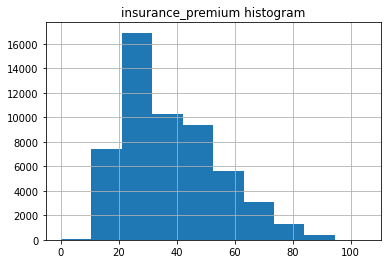

In [82]:
df['insurance_premium'].hist()
plt.title('insurance_premium histogram')
plt.show()

Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот. пропуски заполним нулями.

In [83]:
#заполним строки с пропусками в столбце insurance_premium
df['insurance_premium'] = df['insurance_premium'].fillna(0.0)

#### Тип участника происшествия (party_type)

Тип участника. Мы рассматриваем только машины. Поэтому данный столбец можно удалить.

In [84]:
#удалим строки с пропусками в столбце party_type
df = df.drop('party_type', axis = 1)

#### Возраст автомобиля (vehicle_age)

In [85]:
df['vehicle_age'].describe()

count    53374.000000
mean         4.857833
std          3.237063
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

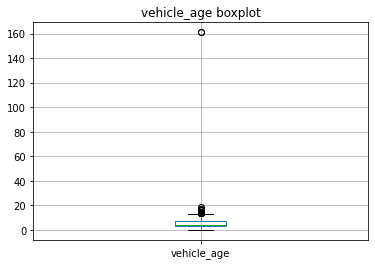

In [86]:
df.boxplot(column = 'vehicle_age')
plt.title('vehicle_age boxplot')
plt.show()

Возраст машины. Честно говоря я не считаю, что возраст машины влияет на виновность в ДТП, но тем не менее по условию заказчика есть требование его использовать. Пропуски заполним медианным значением по столбцу. Все значения старше 12 заменим на 12.

In [87]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 12 if x>12 else x)

#заполним строки с пропусками в столбце vehicle_age
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())

In [88]:
df['vehicle_age'].describe()

count    55007.000000
mean         4.804407
std          2.990041
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         12.000000
Name: vehicle_age, dtype: float64

In [89]:
df['vehicle_age'] = df['vehicle_age'].astype('int')
df['vehicle_age'] = df['vehicle_age'].astype('category')

#### Тип КПП (vehicle_transmission)

In [90]:
#удалим строки с пропусками в столбце county_city_location
df = df.drop('vehicle_transmission', axis = 1)

Различные типы коробки передач никак не корелируют с виновностью в ДТП.

In [91]:
#проверим на пропуски
print('Пропуски по столбцам:')
print(df.isna().mean())

Пропуски по столбцам:
at_fault                       0.0
vehicle_type                   0.0
vehicle_age                    0.0
insurance_premium              0.0
party_sobriety                 0.0
party_drug_physical            0.0
cellphone_in_use               0.0
direction                      0.0
weather_1                      0.0
location_type                  0.0
party_count                    0.0
type_of_collision              0.0
motor_vehicle_involved_with    0.0
road_surface                   0.0
road_condition_1               0.0
lighting                       0.0
control_device                 0.0
collision_date                 0.0
collision_time                 0.0
dtype: float64


In [96]:
df.duplicated().sum()

379

In [97]:
df.drop_duplicates()

Для модели будем использовать следующий набор признаков.

1. `vehicle_type` - тип кузова, Аварийности зависит от паттернов поведения водителя, люди предпочитающие скорость - выбирают купе, а семейные, предпочитающие вместительность, чаще выбирают minivan.
1. `collision_time` - время проишествия. От вермени суток аварийность зависит.
1. `collision_date` - дата проишествия. Важная информация, но она у нас не по всему году. Оставим преобразовав ко дню недели.
1. `control_device` - устройство управления. Не понятный мне столбец. Оставим на всякий случай. Если будут плохие метрики, можно попробовать удалить.
1. `lighting` - освещенность, важный фактор, влияет на видимость на дороге.
1. `road_condition_1` - состояние улицы важнейший фактор влияющий на вероятность ДТП.
1. `road_surface` - состояние покрытия - важнейший фактор.
1. `motor_vehicle_involved_with` - объект, с которым произошло ДТП. зависимость виновности в ДТП от объекта с которым произошло столкновение может существовать. Например fixed object не может двигаться и не может быть виновником ДТП.
1. `type_of_collision` - тип проишествия. Виновность в дтп может зависить от типа столкновения.
1. `party_count` - количество участников. Если участник один, то крайне вероятно, что он виновен
1. `location_type` - тип дороги. Поведение водителей разнится в зависимости от нахождения на шоссе и в городе.
1. `weather_1` - погода. Погада важный фактор при вождении.
1. `direction` - направление движения. Совместно со временем движения может свидетельствовать а том куда светит солнце.
1. `cellphone_in_use` - Наличие телефона в машине, может стать причиной аварии.
1. `party_drug_physical` - Состояние участника. Состояние водителя сильно влияет на его вождение.
1. `party_sobriety` - трезвость участника. Так же сильно влияет на поведение и рекцию вадотеля.
1. `insurance_premium` - страховая премия. Может влиять на поведение водителя. Полное покрытие страховкой может делать водителя более рисковым и наоборот.
1. `vehicle_age` - возраст машины нужно использовать по требованию заказчика

In [99]:
numeric = ['insurance_premium']
category = list(set(df.columns) - set(numeric) - set(['at_fault']))
category, numeric

(['party_sobriety',
  'vehicle_type',
  'collision_date',
  'party_count',
  'lighting',
  'vehicle_age',
  'road_surface',
  'direction',
  'type_of_collision',
  'road_condition_1',
  'collision_time',
  'location_type',
  'control_device',
  'party_drug_physical',
  'weather_1',
  'motor_vehicle_involved_with',
  'cellphone_in_use'],
 ['insurance_premium'])

In [100]:
#Разделим данные на признаки а целефой столббец
X = df.drop('at_fault', axis = 1)
y = df['at_fault']

#разделим данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                test_size = 0.5,
                                                random_state = 42)
print('X - size:', X.shape)
print('X - Train size:', X_train.shape)
print('X - Test size:', X_test.shape)
print('X - Validation size:', X_val.shape)
print('y - size:', y.shape)
print('y - Train size:', y_train.shape)
print('y - Test size:', y_test.shape)
print('y - Validation size:', y_val.shape)

X - size: (55007, 18)
X - Train size: (38504, 18)
X - Test size: (8251, 18)
X - Validation size: (8252, 18)
y - size: (55007,)
y - Train size: (38504,)
y - Test size: (8251,)
y - Validation size: (8252,)


In [101]:
#инициализация StandardScaler
scaler = StandardScaler()
#скалер обучаем только на трейне
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
X_val[numeric] = scaler.transform(X_val[numeric])

In [102]:
X_train_c = X_train
X_test_c = X_test
X_val_c = X_val

In [103]:
#инициализация OneHotEncoder
enc = OneHotEncoder(handle_unknown='error', sparse = 'False', drop='first')
#OneHotEncoder обучаем только на трейне
enc.fit(X_train[category])
#получим закодированные категории
X_train_cat =pd.DataFrame(enc.transform(X_train[category]).toarray(), index = X_train.index)
X_test_cat =pd.DataFrame(enc.transform(X_test[category]).toarray(), index = X_test.index)
X_val_cat =pd.DataFrame(enc.transform(X_val[category]).toarray(), index = X_val.index)

#объединим столбцы с числовыми признаками и столбцы с закодированными категориями
X_train =  X_train.drop(category, axis = 1).join(X_train_cat)
X_test = X_test.drop(category, axis = 1).join(X_test_cat)
X_val = X_val.drop(category, axis = 1).join(X_val_cat)

#Проверим размерности признаков
print('X - Train size:', X_train.shape)
print('X - Test size:', X_test.shape)
print('X - Val size:', X_val.shape)

X - Train size: (38504, 87)
X - Test size: (8251, 87)
X - Val size: (8252, 87)


##### Вывод
Признаки отобраны. Числовые данные нормализированы, категориальные обработаны. Пропуски заполнены и удалены по необходимости.

recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм. Так как нам необходимо предскказать будет ли являться наш клиент виновником проишествия, то мы выберем метрику `recall`.

### LogisticRegression

In [104]:
lr_model = LogisticRegression(C = 0.5,
                              random_state=42,
                              class_weight = 'balanced',
                              penalty = 'l1',
                              solver = 'liblinear',
                              max_iter = 1000)
lr_model.fit(X_train, y_train.values.ravel())
lr_model.predict_proba(X_val)[:,1]
roc_auc_score(y_val.values.ravel(), lr_model.predict_proba(X_val)[:,1])

0.7680373376321077

In [105]:
recall_score(y_val.values.ravel(), lr_model.predict(X_val))

0.5160125210691067

In [106]:
def objective_lr(trial):

    param = {
        'C' : trial.suggest_float("C", 0.1, 100, log=True),
        'penalty' : trial.suggest_categorical('penalty', ["l1", "l2"]),
        'max_iter' : trial.suggest_int('max_iter', 100, 1000, log=True),
    }

    model = LogisticRegression(random_state=42, class_weight = 'balanced', solver = 'liblinear', **param)
    model.fit(X_train, y_train.values.ravel())

    accuracy = roc_auc_score(y_test.values.ravel(), model.predict_proba(X_test)[:, 1])

    return accuracylr_model.predict_proba(X_val)[:,1]

In [107]:
#%%time
#study_lr = optuna.create_study(direction='maximize')
#study_lr.optimize(objective_lr, n_trials=100, timeout=600, n_jobs=-1)

In [108]:
#best_params_lr = study_lr.best_trial.params
#best_params_lr

In [109]:
best_params_lr = {'C': 0.3736798851901106, 'penalty': 'l1', 'max_iter': 104}

{'C': 0.3736798851901106, 'penalty': 'l1', 'max_iter': 104}

In [110]:
model = LogisticRegression(random_state=42,
                           class_weight = 'balanced',
                           solver = 'liblinear',
                           C=0.2950940279038015,
                           penalty= 'l1',
                           max_iter= 886)
model.fit(X_train, y_train.values.ravel())

#roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val)[:, 1])

LogisticRegression(C=0.2950940279038015, class_weight='balanced', max_iter=886,
                   penalty='l1', random_state=42, solver='liblinear')

In [111]:
recall_score(y_val.values.ravel(), lr_model.predict(X_val))

0.5160125210691067

### LightGBM

In [112]:
def objective_lgbm(trial):

    param = {
        'max_depth' : trial.suggest_int("max_depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'num_leaves' : trial.suggest_int("num_leaves", 3, 20)
        ###
    }

    model = lgb.LGBMClassifier(n_jobs=-1, random_state = 42,  **param)
    model.fit(X_train_c, y_train.values.ravel())

    accuracy = roc_auc_score(y_val.values.ravel(), model.predict_proba(X_val_c)[:, 1])

    return accuracy

In [113]:
#%%time
#study_lgbm = optuna.create_study(direction='maximize')
#study_lgbm.optimize(objective_lgbm, n_trials=500, timeout=600, n_jobs=-1)

In [114]:
#best_params_lgbm = study_lgbm.best_trial.params
#best_params_lgbm

{'max_depth': 10,
 'n_estimators': 2307,
 'learning_rate': 0.022953460147270968,
 'num_leaves': 19}

In [115]:
best_params_lgbm = {'max_depth': 10,
 'n_estimators': 2307,
 'learning_rate': 0.022953460147270968,
 'num_leaves': 19}

In [116]:
model_lgb = lgb.LGBMClassifier(random_state = 42, **best_params_lgbm)

In [117]:
model_lgb.fit(X_train_c, y_train.values.ravel())

LGBMClassifier(learning_rate=0.022953460147270968, max_depth=10,
               n_estimators=2307, num_leaves=19, random_state=42)

In [118]:
#roc_auc_score(y_val.values.ravel(), model_lgb.predict_proba(X_val_c)[:, 1])

In [119]:
recall_score(y_val.values.ravel(), model_lgb.predict(X_val_c))

0.5709125933060438

В срачнении и первой моделью качество улучшилось. Попробуем третью модель.

### CatBoostClassifier

In [120]:
def objective(trial):

    param = {
        'depth' : trial.suggest_int("depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 500, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True)

    }

    model = CatBoostClassifier(cat_features=category,
                               early_stopping_rounds = 100,
                               loss_function= 'Logloss',
                               random_state = 42,
                               **param)

    model.fit(X_train_c, y_train, eval_set=[(X_val_c, y_val)], verbose=0)

    accuracy = roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1])

    return accuracy

In [121]:
#%%time
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=500, timeout=600, n_jobs=-1)

[I 2023-07-05 20:40:35,305] A new study created in memory with name: no-name-a3c6ba02-fe12-48be-a780-a9543ea780be
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2023-07-05 20:48:20,266] Trial 3 finished with value: 0.7803921037631878 and parameters: {'depth': 7, 'n_estimators': 1438, 'learning_rate': 0.19574062014485877}. Best is trial 3 with value: 0.78039210376

CPU times: user 30min 48s, sys: 55.9 s, total: 31min 44s
Wall time: 31min 52s


In [122]:
#best_params = study.best_trial.params
#best_params

{'depth': 5, 'n_estimators': 2087, 'learning_rate': 0.044357751107132824}

In [123]:
best_params = {'depth': 5, 'n_estimators': 2087, 'learning_rate': 0.044357751107132824}

In [124]:
model = CatBoostClassifier(cat_features=category,
                           early_stopping_rounds = 100,
                           loss_function='Logloss',
                           random_state = 42,
                           ** best_params
                          )
model.fit(X_train_c, y_train, eval_set=[(X_test_c, y_test)], verbose=3)
roc_auc_score(y_val, model.predict_proba(X_val_c)[:, 1])

0:	learn: 0.6793748	test: 0.6795486	best: 0.6795486 (0)	total: 124ms	remaining: 4m 18s
3:	learn: 0.6449671	test: 0.6453236	best: 0.6453236 (3)	total: 486ms	remaining: 4m 12s
6:	learn: 0.6204125	test: 0.6208738	best: 0.6208738 (6)	total: 771ms	remaining: 3m 49s
9:	learn: 0.6013618	test: 0.6018169	best: 0.6018169 (9)	total: 1.04s	remaining: 3m 35s
12:	learn: 0.5899875	test: 0.5905620	best: 0.5905620 (12)	total: 1.26s	remaining: 3m 21s
15:	learn: 0.5807548	test: 0.5816659	best: 0.5816659 (15)	total: 1.51s	remaining: 3m 15s
18:	learn: 0.5719436	test: 0.5729757	best: 0.5729757 (18)	total: 1.76s	remaining: 3m 11s
21:	learn: 0.5656462	test: 0.5668547	best: 0.5668547 (21)	total: 2.03s	remaining: 3m 10s
24:	learn: 0.5609135	test: 0.5622425	best: 0.5622425 (24)	total: 2.29s	remaining: 3m 8s
27:	learn: 0.5572586	test: 0.5587847	best: 0.5587847 (27)	total: 2.56s	remaining: 3m 8s
30:	learn: 0.5543757	test: 0.5558972	best: 0.5558972 (30)	total: 2.85s	remaining: 3m 9s
33:	learn: 0.5517863	test: 0.553

0.781364779379512

Проведем тестирование лучшей модели на тестовой выборке

In [125]:
#roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1])

In [126]:
recall_score(y_val.values.ravel(), model.predict(X_val_c))

0.5752468095352757

Самое лучшее качество получилось на модели CatBoost. Ее результаты будем использовать для оценки важности параметров. Проведем небольшой анализ качества модели. Построим ROC_AUC кривую, рассмотрим матрицу ошибок, полноту и точность.

### Анализ лучшей модели

0.7865789865492679
Threshold value is: 0.4827261068236231


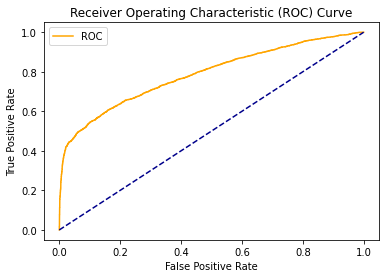

In [127]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_c)[:, 1])
print(roc_auc_score(y_test, model.predict_proba(X_test_c)[:, 1]))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [128]:
cm = confusion_matrix(y_test, model.predict_proba(X_test_c)[:, 1]>=optimal_threshold)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[3479  659]
 [1619 2494]]

True Positives(TP) =  3479

True Negatives(TN) =  2494

False Positives(FP) =  659

False Negatives(FN) =  1619


In [129]:
print('\nTrue Positives(TP) = ', cm[0,0]/len(y_test))
print('\nTrue Negatives(TN) = ', cm[1,1]/len(y_test))
print('\nFalse Positives(FP) = ', cm[0,1]/len(y_test))
print('\nFalse Negatives(FN) = ', cm[1,0]/len(y_test))


True Positives(TP) =  0.4216458611077445

True Negatives(TN) =  0.3022663919524906

False Positives(FP) =  0.07986910677493637

False Negatives(FN) =  0.1962186401648285


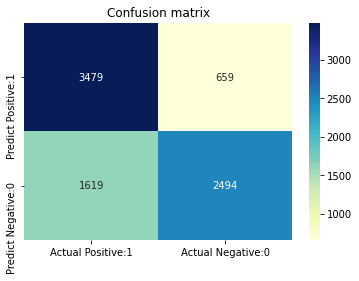

In [130]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion matrix')
plt.show()

Модель хорошо предсказывает Positive так и Negative. Ошибки есть, они смещены в сторону излишненго прогноза Positive

Recall 0.5935468336142548
Precision 0.8021477383664172


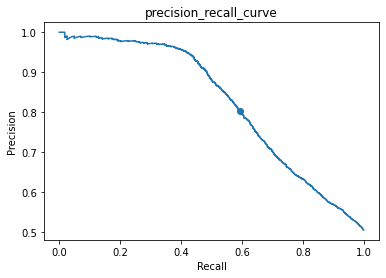

In [131]:
print('Recall', recall_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))
print('Precision', precision_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))

precision, recall, _ = precision_recall_curve(y_val, model.predict_proba(X_val_c)[:, 1])

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(recall_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold),
            precision_score(y_val, model.predict_proba(X_val_c)[:, 1]>=optimal_threshold))
plt.title("precision_recall_curve")
plt.show()

### Вывод
Лучшей моделью стала модель `CatBoostClassifier`. С метрикой ROC-AUC -- 0.85, что является максимальной из рассмотренных моделей. Модель хорошо предсказывает и Positive и Negative классы. Так же модель больше ошибается при прогнозировании позитивного класса, чем негативного.

## Анализ важности факторов ДТП

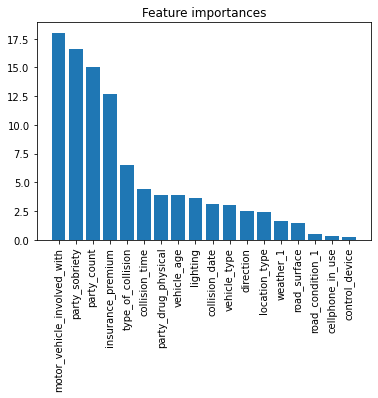

In [132]:
plt.bar(model.get_feature_importance(prettified=True)['Feature Id'],
        model.get_feature_importance(prettified=True)['Importances'])
plt.xticks(rotation = 90)
plt.title('Feature importances')
plt.show()

In [137]:
#sorted(list(zip(model.feature_importances_, X.columns)))

Можно увидель, что модель определила как самые важные признаки
* `collision_time` (время ДТП),
* `insurance_premium` (страховая премия), 
* `vehicle_age` (возраст авто), 
* `collision_date`(день недели),
* `direction0`(направление). 

Рассмотрим подробнее `pcf_violation_category`

In [136]:
fig = px.histogram(
    df, x='collision_time', color='at_fault',
    barmode='group',
    histfunc='count'
)
fig.show()

По столбцу `collision_time` тоже в целом достаточно однозначно можно сделать вывод что ночная езда (c 12 ночи до 5 утра) более опасна, чем дневная. Ночью вероятность ошибки у водителя выше.

## Выводы

Нам удалось обучить модель на тестовых данных и получить метрику Recall равную 64%, precision - 71%.


Мы увидели что самыми влияющими факторами являются (если отсеять одинаковые для всех сторон факторы):

* `collision_time` (время ДТП),
* `insurance_premium` (страховая премия), 
* `vehicle_age` (возраст авто), 
* `collision_date`(день недели),
* `direction0`(направление). 

Ночная езда (c 12 ночи до 5 утра) более опасна, чем дневная. Ночью вероятность ошибки у водителя выше.

Я добавил бы следующие характеристики клиента:
* возраст водителя, который будет прямо влиять на время реакции,
* водительский стаж,
* количество нарушений.
